# EDA

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import pyspark

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
           .config('spark.jars.packages', 'org.xerial:sqlite-jdbc:3.34.0')\
           .getOrCreate()

df = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable='health_events',
                 url='jdbc:sqlite:./health_events.db')\
        .load().toPandas()

24/04/16 17:03:22 WARN Utils: Your hostname, Xiangs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.99.29 instead (on interface en0)
24/04/16 17:03:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/xfu/.ivy2/cache
The jars for the packages stored in: /Users/xfu/.ivy2/jars
org.xerial#sqlite-jdbc added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-83c9d3ed-9f52-4d9c-9b95-a4a41c62678b;1.0
	confs: [default]
	found org.xerial#sqlite-jdbc;3.34.0 in central
:: resolution report :: resolve 49ms :: artifacts dl 1ms
	:: modules in use:
	org.xerial#sqlite-jdbc;3.34.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      

:: loading settings :: url = jar:file:/Users/xfu/anaconda3/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


24/04/16 17:03:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
df.head()

,event_type,timestamp,location,severity,details
0,general_health_report,2024-04-09 18:39:33,Berlin,medium,This is a simulated general_health_report event.
1,routine_checkup,2024-04-09 18:39:41,London,low,This is a simulated routine_checkup event.
2,general_health_report,2024-04-09 18:39:49,Boston,medium,This is a simulated general_health_report event.
3,emergency_incident,2024-04-09 18:40:00,Paris,high,This is a simulated emergency_incident event.
4,general_health_report,2024-04-09 18:40:13,Paris,medium,This is a simulated general_health_report event.


In [26]:
df.dtypes

event_type              object
timestamp       datetime64[ns]
location                object
severity                object
details                 object
num_severity             int64
date                    object
day_of_week             object
dtype: object

In [25]:
df.describe()

,timestamp,num_severity
count,39264,39264.000000
mean,2024-04-13 10:18:34.744753408,1.911344
min,2024-04-09 18:39:33,1.000000
25%,2024-04-12 03:53:45.500000,1.000000
50%,2024-04-13 10:57:35,2.000000
75%,2024-04-14 18:10:37,2.000000
max,2024-04-16 01:30:21,3.000000
std,NaN,0.757988


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

event_type            object
timestamp     datetime64[ns]
location              object
severity              object
details               object
dtype: object

In [5]:
event_type_counts = df.groupby("event_type").size().reset_index(name='count').sort_values(by='count', ascending=False)
print(event_type_counts)

              event_type  count
5            vaccination   6628
1  general_health_report   6609
4        routine_checkup   6576
2         health_mention   6532
0     emergency_incident   6490
3     hospital_admission   6429


In [6]:
severity = {
    'high': 3,
    'medium': 2,
    'low': 1
}

df['num_severity'] = df['severity'].apply(lambda x: severity[x])
df.head()

,event_type,timestamp,location,severity,details,num_severity
0,general_health_report,2024-04-09 18:39:33,Berlin,medium,This is a simulated general_health_report event.,2
1,routine_checkup,2024-04-09 18:39:41,London,low,This is a simulated routine_checkup event.,1
2,general_health_report,2024-04-09 18:39:49,Boston,medium,This is a simulated general_health_report event.,2
3,emergency_incident,2024-04-09 18:40:00,Paris,high,This is a simulated emergency_incident event.,3
4,general_health_report,2024-04-09 18:40:13,Paris,medium,This is a simulated general_health_report event.,2


#### Event type distribution

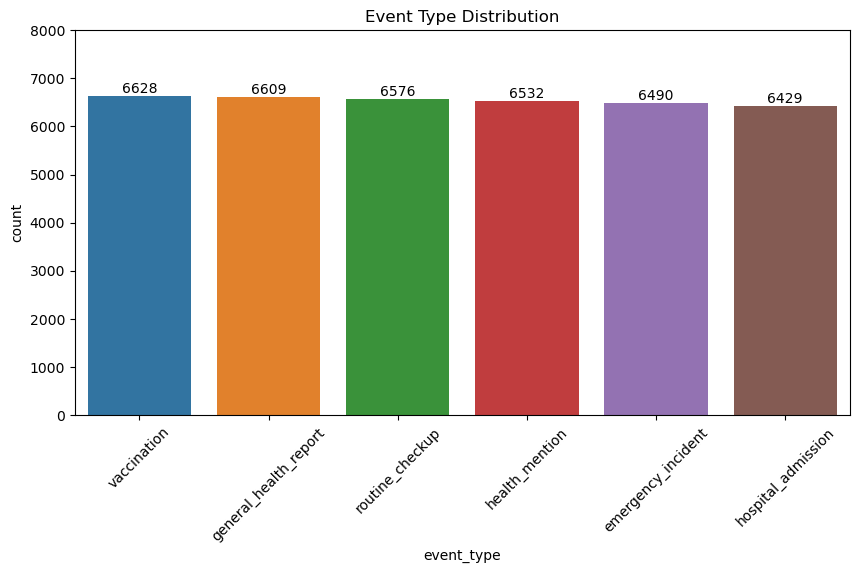

In [7]:
# Plot the event type distribution
plt.figure(figsize=(10,5))
ax = sns.barplot(x='event_type', y='count', data=event_type_counts)
plt.title('Event Type Distribution')
plt.ylim(0, 8000)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility.
plt.show()

#### Geographical distribution

In [8]:
# 4. Geographical Distribution Analysis
location_counts = df['location'].value_counts().reset_index()
location_counts.columns = ['location', 'count']
print(location_counts)

      location  count
0       Berlin   6620
1       London   6579
2        Paris   6567
3     New York   6518
4  Los Angeles   6497
5       Boston   6483


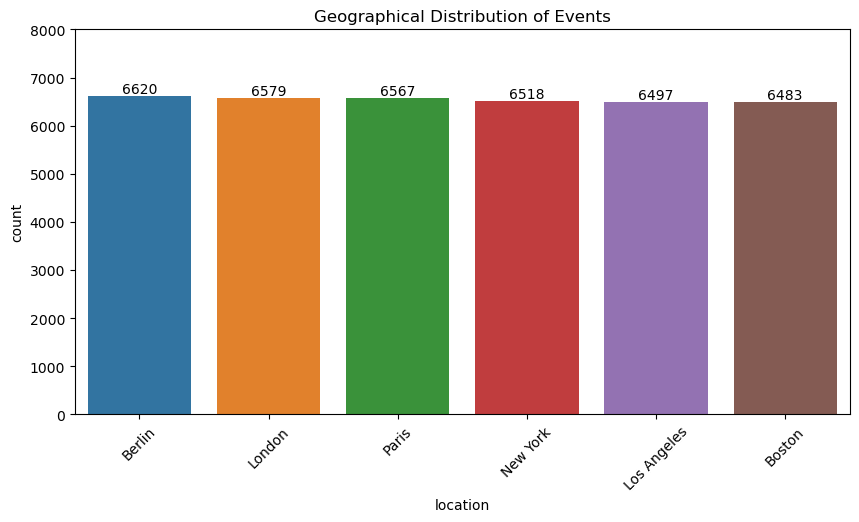

In [10]:
# Plot the geographical distribution
plt.figure(figsize=(10,5))
ax = sns.barplot(x='location', y='count', data=location_counts)
plt.title('Geographical Distribution of Events')
plt.xticks(rotation=45)
plt.ylim(0, 8000)
ax.bar_label(ax.containers[0])
plt.show()

#### Event type relationships

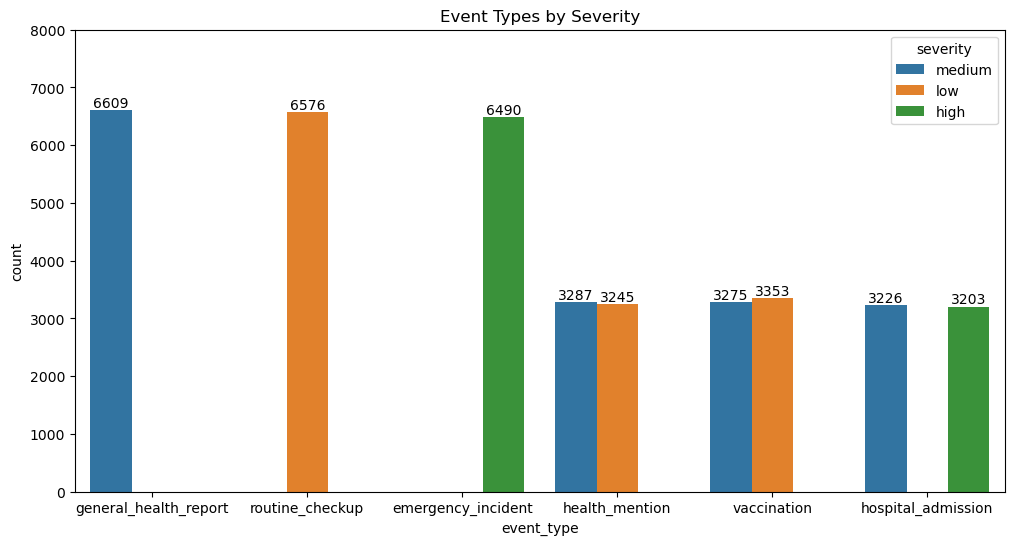

In [9]:
# 5. Event Type Relationships
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='event_type', hue='severity', data=df)
plt.title('Event Types by Severity')
plt.ylim(0, 8000)

for i in ax.containers:
    labels = [int(v) if v > 0 else "" for v in i.datavalues]    
    ax.bar_label(i, labels=labels, label_type='edge')

plt.show()

#### Temporal analysis

In [10]:
# 6. Temporal Analysis
# Convert timestamp to just date if necessary.
df['date'] = pd.to_datetime(df['timestamp']).dt.date
date_counts = df['date'].value_counts().sort_index().reset_index()
date_counts.columns = ['date', 'count']
print(date_counts)

         date  count
0  2024-04-09    670
1  2024-04-10   1544
2  2024-04-11   6391
3  2024-04-12   7589
4  2024-04-13   7537
5  2024-04-14   7556
6  2024-04-15   7514
7  2024-04-16    463


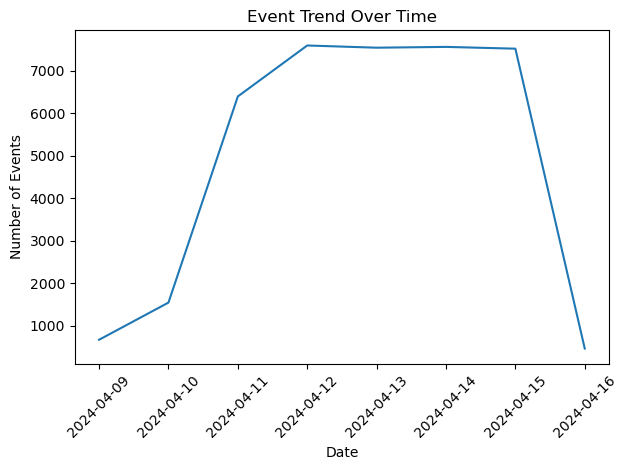

In [11]:
# Plot the trend over time
plt.plot(date_counts['date'], date_counts['count'])
plt.title('Event Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to fit all labels.
plt.show()

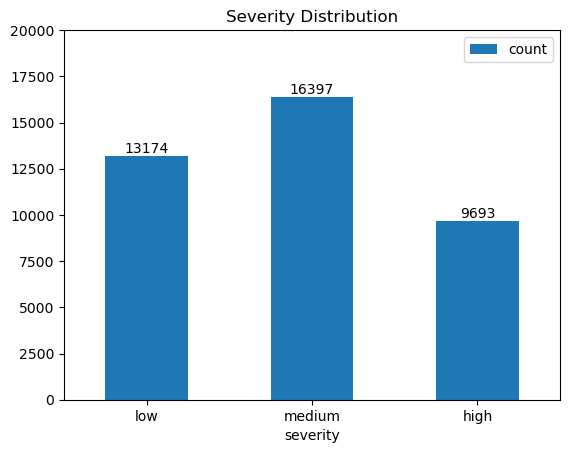

In [12]:
# Understanding how many events are there for each severity level 
severity_counts = df['severity'].value_counts().reset_index()
severity_counts['severity'] = pd.Categorical(severity_counts['severity'], ['low', 'medium', 'high'])
severity_counts.sort_values('severity', inplace=True)
severity_counts.columns = ['severity', 'count']
ax = severity_counts.plot(kind='bar', x='severity', y='count', title='Severity Distribution')
plt.bar_label(ax.containers[0])
plt.xticks(rotation=0)
plt.ylim(0, 20000)
plt.show()

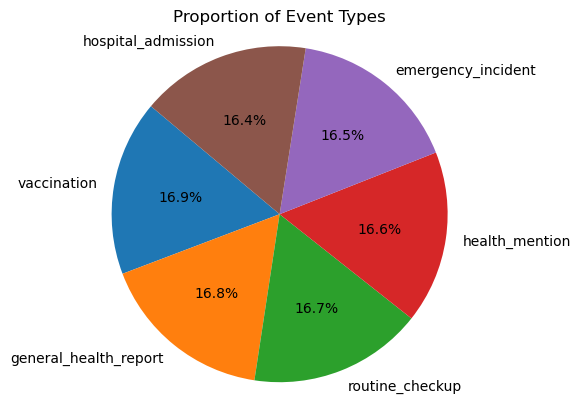

In [13]:
event_type_proportions = df['event_type'].value_counts()
plt.pie(event_type_proportions, labels=event_type_proportions.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Event Types')
plt.show()

#### Heatmap of Event Types and Locations

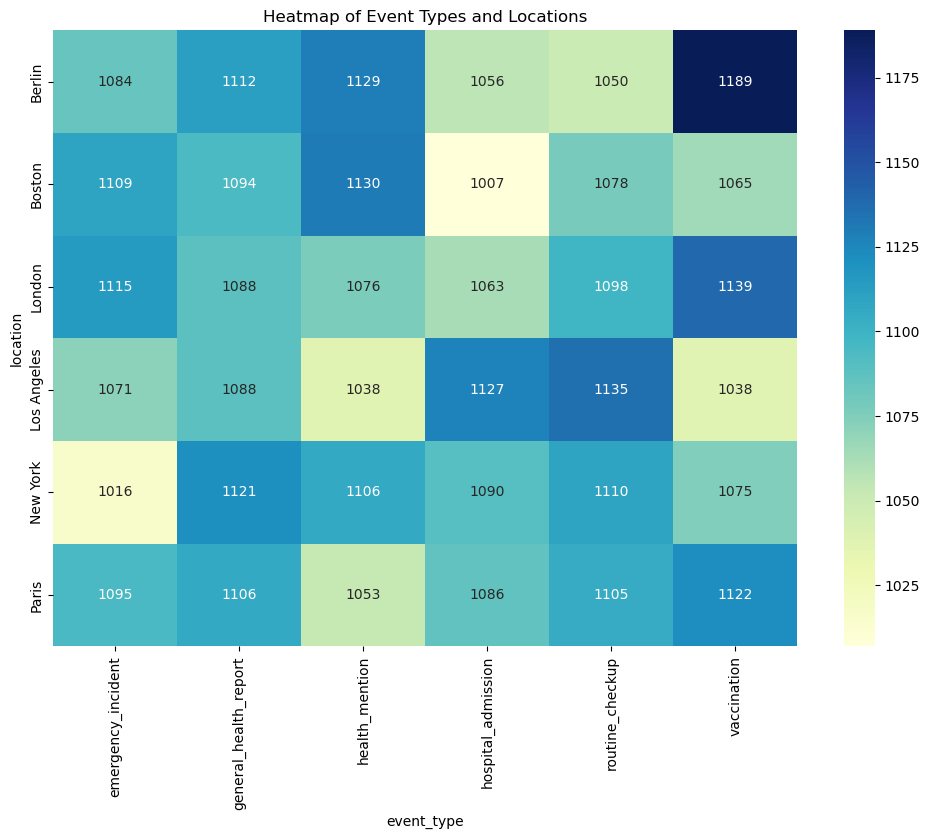

In [14]:
plt.figure(figsize=(12, 8))
location_event_counts = pd.crosstab(df['location'], df['event_type'])
sns.heatmap(location_event_counts, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Event Types and Locations')
plt.show()

#### Stacked Bar Chart of Event Types by Location

<Figure size 1200x600 with 0 Axes>

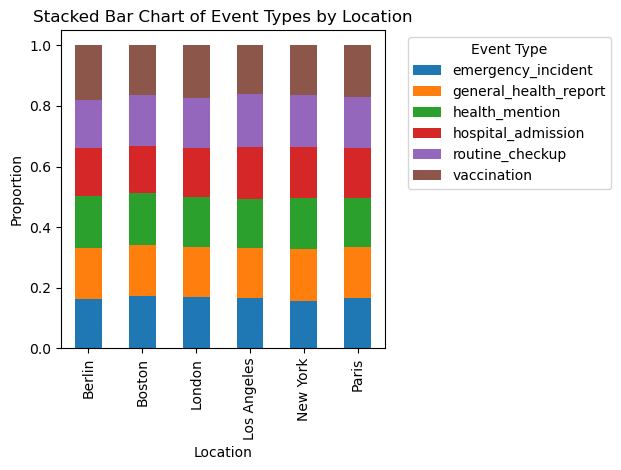

In [15]:
plt.figure(figsize=(12, 6))
location_event_counts_normalized = location_event_counts.div(location_event_counts.sum(axis=1), axis=0)
location_event_counts_normalized.plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Event Types by Location')
plt.xlabel('Location')
plt.ylabel('Proportion')
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Correlation between event type and severity

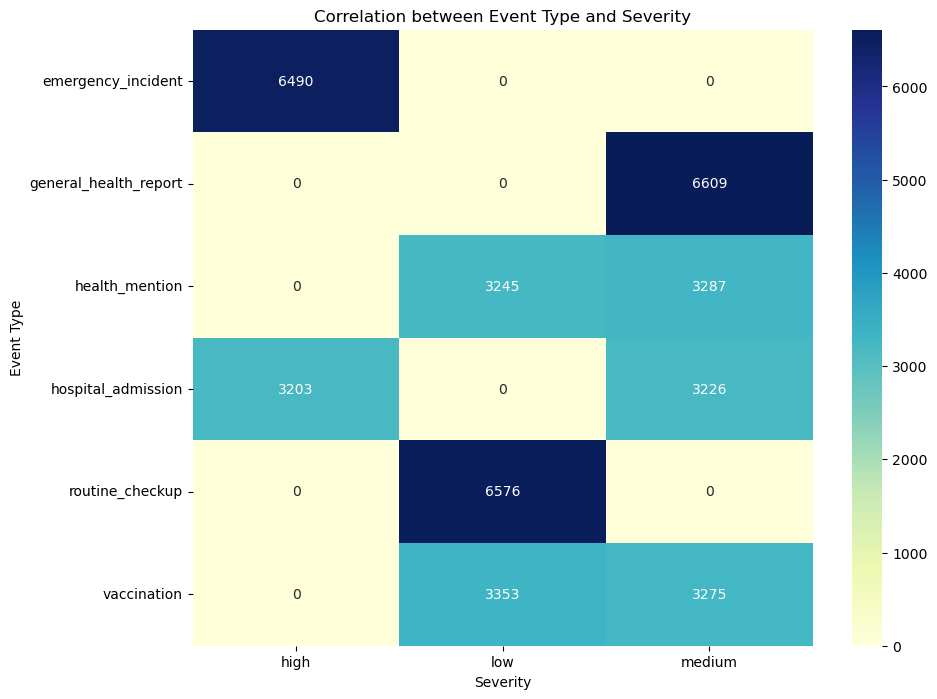

In [16]:
# create a contingency table
contingency_table = pd.crosstab(df['event_type'], df['severity'])

plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Correlation between Event Type and Severity')
plt.xlabel('Severity')
plt.ylabel('Event Type')
plt.show()

#### Correlation Matrix Heatmap

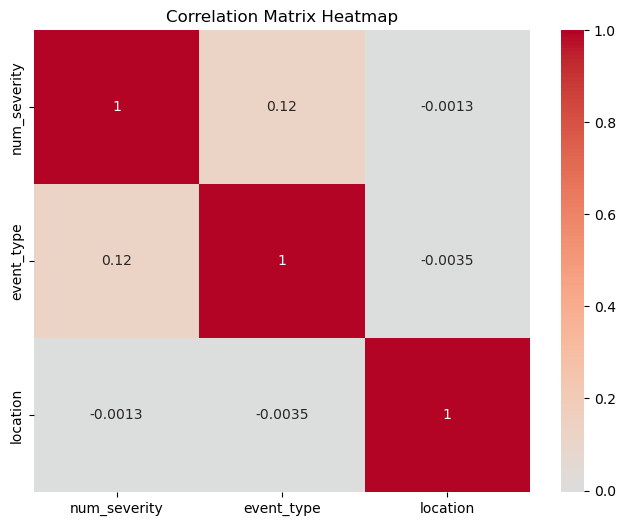

In [20]:
correlation_matrix = df[['num_severity', 'event_type', 'location']].apply(lambda x: pd.factorize(x)[0]).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Stacked Area Chart of Event Types Over Time

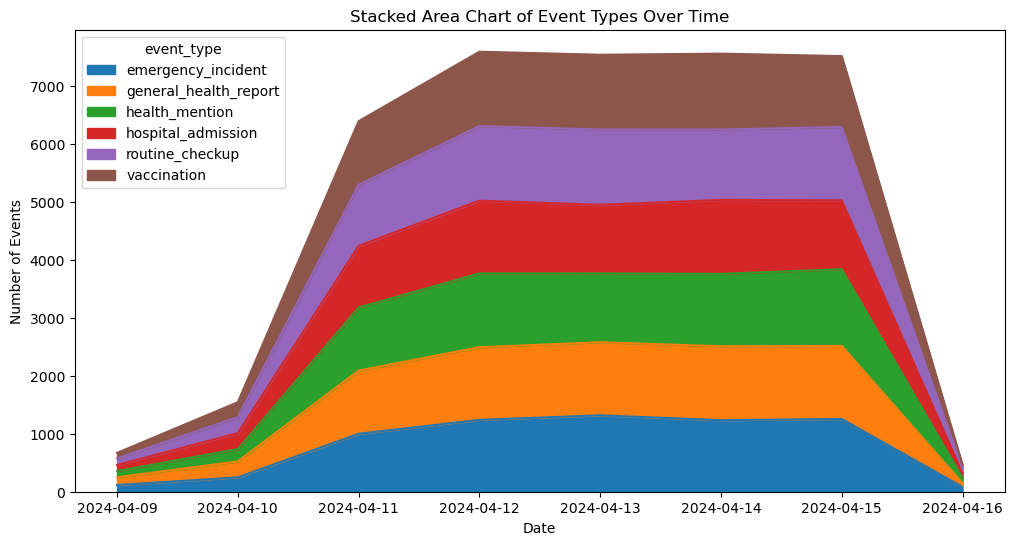

In [21]:
event_type_counts_over_time = df.groupby([df['timestamp'].dt.date, 'event_type']).size().reset_index(name='count')
event_type_counts_over_time_pivot = event_type_counts_over_time.pivot(index='timestamp', columns='event_type', values='count')
event_type_counts_over_time_pivot.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title('Stacked Area Chart of Event Types Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()

#### Top N locations with the highest number of events

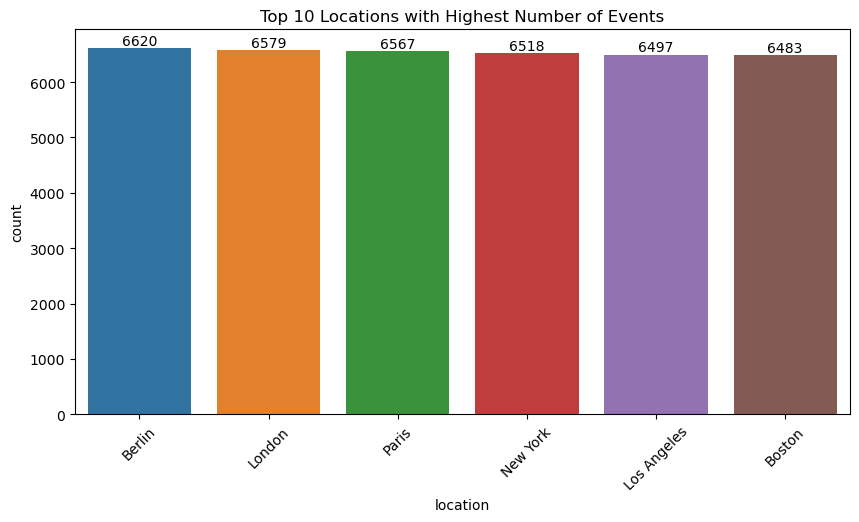

In [22]:
top_n = 10
top_locations = location_counts.head(top_n)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='location', y='count', data=top_locations)
plt.title(f'Top {top_n} Locations with Highest Number of Events')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.show()

#### Event counts by day of the week

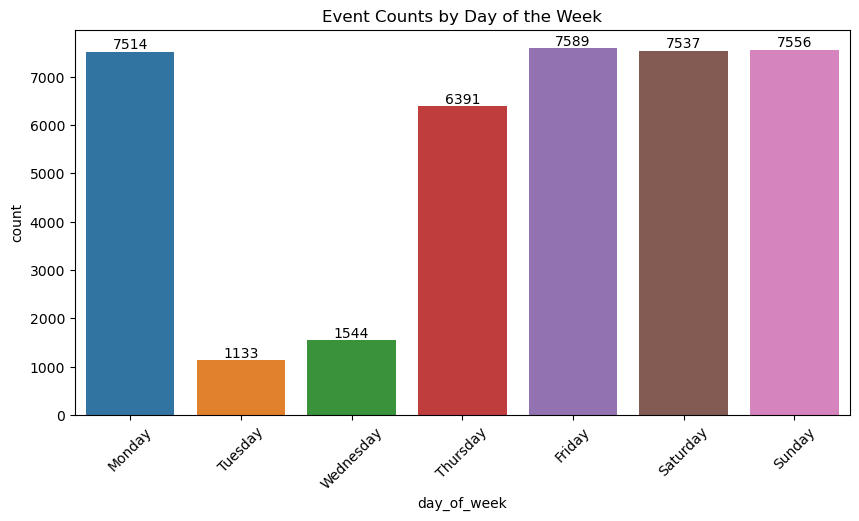

In [37]:
df['day_of_week'] = df['timestamp'].dt.day_name()
day_counts = df['day_of_week'].value_counts().reset_index()
day_counts.columns = ['day_of_week', 'count']

# sort days in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts['day_of_week'] = pd.Categorical(day_counts['day_of_week'], categories=day_order, ordered=True)
day_counts = day_counts.sort_values('day_of_week')

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='day_of_week', y='count', data=day_counts)
plt.title('Event Counts by Day of the Week')
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.show()

#### Average severity by location

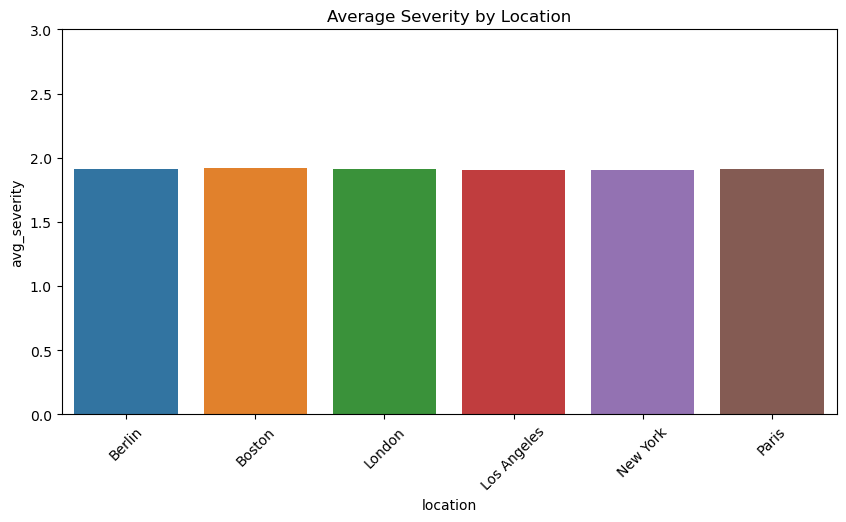

In [38]:
location_severity = df.groupby('location')['num_severity'].mean().reset_index()
location_severity.columns = ['location', 'avg_severity']

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='location', y='avg_severity', data=location_severity)
plt.title('Average Severity by Location')
plt.xticks(rotation=45)
plt.ylim(0, 3)
plt.show()